Imports

In [9]:
import pandas as pd
from IPython.display import display, HTML
 
from termcolor import colored

import plotly.subplots as sp
import plotly.graph_objects as go

Initial Databases before pre-processing

In [10]:
filepath = r'C:\Users\Fede\Desktop\Drive\3_Recursos\Code\tesis_juli\DBs'
#filepath = r'D:\Drive\3_Recursos\Code\tesis_juli\DBs'
max_cols = 15

psilo1_df = pd.read_csv(r'{}/raw/psilopercep.csv'.format(filepath))
show_cols1_df = psilo1_df.iloc[:, :max_cols]
show_cols1_df['...'] = '...'

psilo2_df = pd.read_csv(filepath + '/raw/psilocomp.csv') 
show_cols2_df = psilo2_df.iloc[:, :max_cols]
show_cols2_df['...'] = '...'

display(HTML(show_cols1_df.head().to_html()))
display(HTML(show_cols2_df.head().to_html()))

,Timestamp,ID,Condición,Indique cómo se siente EN ESTE MOMENTO. [Me siento calmado],Indique cómo se siente EN ESTE MOMENTO. [Me siento seguro],Indique cómo se siente EN ESTE MOMENTO. [Estoy tenso],Indique cómo se siente EN ESTE MOMENTO. [Me siento disgustado],Indique cómo se siente EN ESTE MOMENTO. [Me siento “a mis anchas”],Indique cómo se siente EN ESTE MOMENTO. [Me siento alterado],Indique cómo se siente EN ESTE MOMENTO. [En este momento estoy preocupado por algún posible problema],Indique cómo se siente EN ESTE MOMENTO. [Me siento satisfecho],Indique cómo se siente EN ESTE MOMENTO. [Me siento asustado],Indique cómo se siente EN ESTE MOMENTO. [Me siento cómodo],Indique cómo se siente EN ESTE MOMENTO. [Tengo confianza en mí mismo],Indique cómo se siente EN ESTE MOMENTO. [Me siento nervioso],...
0,11/1/2021 17:10:12,S01,A,Bastante,Mucho,Nada,Nada,Bastante,Nada,Nada,Mucho,Nada,Bastante,Mucho,Nada,...
1,11/10/2021 15:08:27,s02,A,Mucho,Mucho,Nada,Nada,Mucho,Nada,Nada,Mucho,Nada,Mucho,Mucho,Nada,...
2,11/10/2021 17:05:36,S03,A,Un poco,Bastante,Un poco,Nada,Nada,Nada,Un poco,Bastante,Nada,Bastante,Bastante,Nada,...
3,11/19/2021 15:27:47,S04,A,Bastante,Bastante,Nada,Nada,Un poco,Nada,Nada,Bastante,Nada,Bastante,Bastante,Nada,...
4,11/24/2021 14:29:54,s05,A,Bastante,Bastante,Nada,Nada,Bastante,Nada,Nada,Bastante,Nada,Bastante,Bastante,Nada,...


,Marca temporal,Nombre y apellido,ID de sujeto,Indique cómo se siente EN ESTE MOMENTO. [Me siento calmado],Indique cómo se siente EN ESTE MOMENTO. [Me siento seguro],Indique cómo se siente EN ESTE MOMENTO. [Estoy tenso],Indique cómo se siente EN ESTE MOMENTO. [Me siento disgustado],Indique cómo se siente EN ESTE MOMENTO. [Me siento “a mis anchas”],Indique cómo se siente EN ESTE MOMENTO. [Me siento alterado],Indique cómo se siente EN ESTE MOMENTO. [En este momento estoy preocupado por algún posible problema],Indique cómo se siente EN ESTE MOMENTO. [Me siento satisfecho],Indique cómo se siente EN ESTE MOMENTO. [Me siento asustado],Indique cómo se siente EN ESTE MOMENTO. [Me siento cómodo],Indique cómo se siente EN ESTE MOMENTO. [Tengo confianza en mí mismo],Indique cómo se siente EN ESTE MOMENTO. [Me siento nervioso],...
0,26/11/2021 17:27:59,Manuel Barberis,4,Mucho,Mucho,Nada,Nada,Mucho,Nada,Nada,Mucho,Nada,Mucho,Mucho,Nada,...
1,26/11/2021 17:30:22,Constanza Muller,1,Mucho,Mucho,Nada,Nada,Mucho,Nada,Nada,Mucho,Nada,Mucho,Mucho,Nada,...
2,26/11/2021 17:36:34,karen Muller,2,Mucho,Mucho,Nada,Nada,Mucho,Nada,Nada,Mucho,Nada,Mucho,Mucho,Nada,...
3,26/11/2021 17:45:37,Lucrecia Grande Rocha,5,Mucho,Mucho,Nada,Nada,Bastante,Nada,Nada,Bastante,Nada,Bastante,Mucho,Nada,...
4,26/11/2021 18:03:22,Joaquin Barberis,3,Bastante,Mucho,Nada,Nada,Bastante,Nada,Un poco,Bastante,Nada,Bastante,Mucho,Nada,...


Pre-proccessing functions

In [11]:
def prepro_psilocomp(filepath):
    # Unblinding de los sujetos de grupos de '3 gramos' vs 'control' (grupos 1, 2, 5, 6, 7)
    cond_lst = [1,2,3,4,5,6,7,8,9,10,21,22,25,26,27,28,29,30,31,32,33,34] 
    
    # Cargo la DB no procesada del experimento de psilocibina y compasión:
    prepro_df = pd.read_csv(r'{}/raw/psilocomp.csv'.format(filepath)) 
    prepro_df = pd.concat([prepro_df.iloc[:,[2]], prepro_df.iloc[:,135:228]], axis=1)
        
    # Algunas columnas fueron exportadas con espacios
    prepro_df.columns = prepro_df.columns.str.strip()    
    # Agrego una columna en la posición 21 de las preguntas, ya que falta. 
    prepro_df.insert(21, 'Me sentí atormentado/a.', 1)    
    # Mantengo aquellos sujetos que estén en la lista de dosis activa:
    prepro_df = prepro_df[prepro_df['ID de sujeto'].isin(cond_lst)]

    # Ahora cargo las excalas pre, con las cuales haré el merge.
    basal_df = pd.read_csv(r'{}/raw/psilocomp_basal.csv'.format(filepath)) 
    basal_df = pd.concat([basal_df.iloc[:,[2]], basal_df.iloc[:,3:47]], axis=1)
    # Algunas columnas fueron exportadas con espacios. También normalizo los IDS
    basal_df.columns = basal_df.columns.str.strip()
    # Me quedo solo con la primera escala BFI, que fue la que respondieron antes de la toma:
    basal_df = basal_df.drop_duplicates(subset=["ID de sujeto"], keep="first")
    # Mantengo aquellos sujetos que estén en la lista de dosis activa:
    basal_df = basal_df[basal_df['ID de sujeto'].isin(cond_lst)]    
    
    # Uno databases y 5D-ASC basado en el ID de sujeto
    result_df = prepro_df.merge(basal_df, how='left', on=['ID de sujeto']) 
    # Reinicio el índice
    result_df = result_df.reset_index(drop=True)     
    
    return result_df

# -------------------------------------------------------------------------------------------------------------------------------------------
def prepro_dmt(filepath):
    # Cargo la DB ya procesada del experimento de DMT:
    prepro_df = pd.read_csv(filepath + '/raw/dmt.csv')
    # Me quedo solamente con los features que voy a utilizar.
    prepro_df = pd.concat([prepro_df.iloc[:,13:18], prepro_df.iloc[:,43:54], prepro_df.iloc[:,20]], axis=1)
    prepro_df.reset_index(drop=True)
    # Renombro aquellas columnas que voy a utilizar (BFI basal, pre experimento)
    prepro_df = prepro_df.rename(columns={"BFI1-E": "BFI-E", "BFI1-A": "BFI-A", "BFI1-C": "BFI-C", 
                                          "BFI1-N": "BFI-N", "BFI1-O": "BFI-O"})
    
    return prepro_df

# -------------------------------------------------------------------------------------------------------------------------------------------
def prepro_psilopercep(filepath):  
    # Cargo la DB no procesada del experimento de psilocibina y percepción:
    prepro_df = pd.read_csv(r'{}/raw/psilopercep.csv'.format(filepath))
    prepro_df = pd.concat([prepro_df.iloc[:,[1,2]], prepro_df.iloc[:,126:]], axis=1)
    # Algunas columnas fueron exportadas con espacios
    prepro_df.columns = prepro_df.columns.str.strip()
    # Normalizo los IDs
    prepro_df['ID'] = prepro_df['ID'].str.upper()
    # Agrego una columna con la dosis
    prepro_df.insert(2, 'Dosis', 0)
    # Agrego una columna en la posición 21 de las preguntas, ya que falta: 
    prepro_df.insert(21+2, 'Me sentí atormentado/a.', 1)
    
    # Unblinding de dosis
    condA_dict = {'S01':'alta',
                  'S02':'alta',
                  'S03':'alta',
                  'S04':'baja',
                  'S05':'baja',
                  'S06':'alta',
                  'S07':'baja',
                  'S08':'baja',
                  'S09':'alta',
                  'S10':'baja',
                  'S11':'baja',
                  'S12':'alta',
                  'S13':'baja',
                  'S14':'alta'}
    
    # Ahora asigno la dosis a cada condición del diccionario (y para la condición B, que no está en el dict)
    for key in condA_dict:
      prepro_df.loc[(prepro_df['ID'] == key) & (prepro_df['Condición'] == 'A'),'Dosis'] = condA_dict[key]
      prepro_df.loc[(prepro_df['ID'] == key) & (prepro_df['Condición'] == 'B'),'Dosis'] = 'baja' if condA_dict[key] == 'alta' else 'alta'    
    # Me quedo solo con las columnas y rows útiles para la comparación (de la condición alta)
    prepro_df = prepro_df[prepro_df['Dosis'] == 'alta']
    # Ahora cargo el BFI, con el cual haré el merge.
    prepro_bfi_df = pd.read_csv(r'{}/raw/psilopercep_basal.csv'.format(filepath)) 
    prepro_bfi_df = pd.concat([prepro_bfi_df.iloc[:,[1,2]], prepro_bfi_df.iloc[:,23:67]], axis=1)
    # Algunas columnas vienen con espacios, las acomodo. También normalizo los IDS
    prepro_bfi_df.columns = prepro_bfi_df.columns.str.strip()
    prepro_bfi_df['ID'] = prepro_bfi_df['ID'].str.upper()    
    # Uno BFI y 5DASC basado en el ID de sujeto
    prepro_df = prepro_df.merge(prepro_bfi_df, how='left', on=['ID','Condición']) 
    # Elimino las columnas que no necesito
    prepro_df.drop(['Condición','Dosis'], axis=1, inplace=True)
    # Reinicio el índice
    prepro_df = prepro_df.reset_index(drop=True)          
      
    return prepro_df

Range normalising functions

In [12]:
def proc_rerange(df, col_name, from_min, from_max, to_max):
    # Evalúo si debo correr el puntaje para que tenga un mínimo de 0 y el mismo rango            
    if from_min > 0:
        from_max = from_max - from_min        
    
    # Modifico la columna para que tome valores entre 0 y to_max:
    for i in range(len(df)): 
      act_value = df.loc[i, col_name]      
      # Solo modifico el valor si el usuario llenó el campo
      if act_value != -999:
          # Si el mínimo no es 0, también tengo que correr el puntaje de la columna
          if from_min > 0:
              act_value = act_value-from_min
    
          new_value = (act_value*to_max)/from_max         
          new_value = round(new_value, 2)
      else:
          new_value = act_value
          
      df.loc[i, col_name+'_reranged'] = new_value
    
    return df

# -------------------------------------------------------------------------------------------------------------------------------------------
def normalize_ranges(df, min, max):
    # Normalizo las columnas
    max_value = 10
    
    df = proc_rerange(df, 'BFI-E', 8, 40, max_value)
    df = proc_rerange(df, 'BFI-A', 9, 45, max_value)
    df = proc_rerange(df, 'BFI-C', 9, 45, max_value)
    df = proc_rerange(df, 'BFI-N', 8, 40, max_value)
    df = proc_rerange(df, 'BFI-O', 10, 50, max_value)  
    
    df = proc_rerange(df, '5D-Unity', min*5, max*5, max_value)
    df = proc_rerange(df, '5D-Spiritual', min*3, max*3, max_value)
    df = proc_rerange(df, '5D-Blissful', min*3, max*3, max_value)
    df = proc_rerange(df, '5D-Insightfulness', min*3, max*3, max_value)
    df = proc_rerange(df, '5D-Disembodiment', min*3, max*3, max_value) 
    df = proc_rerange(df, '5D-ImpairedC&C', min*7, max*7, max_value)
    df = proc_rerange(df, '5D-Anxiety', min*6, max*6, max_value)
    df = proc_rerange(df, '5D-ComplexImagery', min*3, max*3, max_value)
    df = proc_rerange(df, '5D-ElementaryImagery', min*3, max*3, max_value)
    df = proc_rerange(df, '5D-AudioVisualSyn', min*3, max*3, max_value)        
    df = proc_rerange(df, '5D-ChangedMeaning', min*3, max*3, max_value)
    
    return df

Score scales

In [13]:
def proc_score_extended_bfi(df):
    # Calculo estabilidad emocional
    neuroticism_maxvalue = 40
    df['BFI-ES'] = neuroticism_maxvalue-df.loc[:,['BFI-N']]
    # Calculo los factores de segundo orden:
    # factor alpha = agreeableness + conscientiousness + emotional stability
    # factor beta = extraversion + openness
    df['BFI-FAP'] = df.loc[:,['BFI-A','BFI-C','BFI-ES']].sum(axis=1)
    df['BFI-FBP'] = df.loc[:,['BFI-E','BFI-O']].sum(axis=1)
    # Calculo factor de tercer orden:
    # factor general = agreeableness + conscientiousness + emotional stability + extraversion + openness
    df['BFI-FGP'] = df.loc[:,['BFI-A','BFI-C','BFI-ES','BFI-E','BFI-O']].sum(axis=1)
    return df
    
def proc_score(df):
    bfi_df = df.iloc[:,95:]
    d5asc_df = df.iloc[:,1:95]
    result_df = pd.DataFrame()
    
    # BFI    
    # Invierto los valores de las columnas negadas
    bfi_df.iloc[:,[1,5,7,8,11,17,20,22,23,26,30,33,34,36,40,42]] = bfi_df.iloc[:,[1,5,7,8,11,17,20,22,23,26,30,33,34,36,40,42]].replace([1,2,4,5],[5,4,2,1])

    # 21 preguntas. La escala se puntúa de 1 a 5 y la puntuación es directa a los siguientes factores: 
    # Extraversion: 1,6R,11,16,21R,26,31R,36 (índices: 0,5,10,15,20,25,30,35)
    result_df['BFI-E'] = bfi_df.iloc[:,[0,5,10,15,20,25,30,35]].sum(axis=1)
    # Agreeability: 2R,7,12R,17,22,27R,32,37R,42 (índices: 1,6,11,16,21,26,31,36,41)
    result_df['BFI-A'] = bfi_df.iloc[:,[1,6,11,16,21,26,31,36,41]].sum(axis=1)
    # Conscientiousness: 3,8R,13,18R,23R,28,33,38,43R (índices: 2,7,12,17,22,27,32,37,42)
    result_df['BFI-C'] = bfi_df.iloc[:,[2,7,12,17,22,27,32,37,42]].sum(axis=1)   
    # Neuroticism: 4,9R,14,19,24R,29,34R,39 (índices: 3,8,13,18,23,28,33,38)
    result_df['BFI-N'] = bfi_df.iloc[:,[3,8,13,18,23,28,33,38]].sum(axis=1)       
    # Openness: 5,10,15,20,25,30,35R,40,41R,44 (índices: 4,9,14,19,24,29,34,39,40,43)
    result_df['BFI-O'] = bfi_df.iloc[:,[4,9,14,19,24,29,34,39,40,43]].sum(axis=1)          
    # Calculo los factores extendidos:
    result_df = proc_score_extended_bfi(result_df)    
    
    # 5D-ASC
    result_df['5D-Unity'] = d5asc_df.iloc[:,[x for x in [17, 33, 40, 41, 51]]].sum(axis=1)
    result_df['5D-Spiritual'] = d5asc_df.iloc[:,[x for x in [8, 80, 93]]].sum(axis=1)
    result_df['5D-Blissful'] = d5asc_df.iloc[:,[x for x in [11, 85, 90]]].sum(axis=1)
    result_df['5D-Insightfulness'] = d5asc_df.iloc[:,[x for x in [49, 68, 76]]].sum(axis=1)
    result_df['5D-Disembodiment'] = d5asc_df.iloc[:,[x for x in [25, 61, 62]]].sum(axis=1)
    result_df['5D-ImpairedC&C'] = d5asc_df.iloc[:,[x for x in [7, 26, 37, 46, 63, 66, 77]]].sum(axis=1)
    result_df['5D-Anxiety'] = d5asc_df.iloc[:,[x for x in [31, 42, 43, 45, 55, 88]]].sum(axis=1)
    result_df['5D-ComplexImagery'] = d5asc_df.iloc[:,[x for x in [38, 71, 81]]].sum(axis=1)
    result_df['5D-ElementaryImagery'] = d5asc_df.iloc[:,[x for x in [13, 21, 32]]].sum(axis=1)
    result_df['5D-AudioVisualSyn'] = d5asc_df.iloc[:,[x for x in [19, 22, 74]]].sum(axis=1)
    result_df['5D-ChangedMeaning'] = d5asc_df.iloc[:,[x for x in [27, 30, 53]]].sum(axis=1) 
    
    return result_df

Pre procesado

In [18]:
#filepath = r'D:\Drive\3_Recursos\Code\tesis_juli\DBs'
filepath = r'C:\Users\Fede\Desktop\Drive\3_Recursos\Code\tesis_juli\DBs'

# Cargo las DB que contienen los datos en bruto y las pre-proceso para que queden utilizables:
psilopercep_df = prepro_psilopercep(filepath)
psilocomp_df = prepro_psilocomp(filepath)

# Puntúo las escalas del experimento de compasión y percepción, ya que las del experimento de DMT están puntuadas:        
db1 = proc_score(psilopercep_df)
db2 = proc_score(psilocomp_df)
# Luego uno las DB de los experimentos de psilocibina (percepción y compasión)
psilo_df = pd.concat([db1, db2], axis=0).reset_index(drop=True)       
# Transformo los puntajes (no uso z-scores ya que no puedo realizar el análisis de varianza sino)
psilo_df = normalize_ranges(psilo_df, 1, 10)

# Hago lo mismo con las escalas de DMT
dmt_df = prepro_dmt(filepath)
dmt_df = proc_score_extended_bfi(dmt_df)
dmt_df = normalize_ranges(dmt_df, 0, 90)
            
# Guardo
psilo_df.to_csv(r'{}\psilo_scored.csv'.format(filepath))
dmt_df.to_csv(r'{}\dmt_scored.csv'.format(filepath))

C:\Users\Fede\AppData\Local\Temp\ipykernel_3420\2879288050.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bfi_df.iloc[:,[1,5,7,8,11,17,20,22,23,26,30,33,34,36,40,42]] = bfi_df.iloc[:,[1,5,7,8,11,17,20,22,23,26,30,33,34,36,40,42]].replace([1,2,4,5],[5,4,2,1])


Work databases after pre-processing

In [19]:
psilo_df = pd.read_csv(r'{}\psilo_scored.csv'.format(filepath))
dmt_df = pd.read_csv(r'{}\dmt_scored.csv'.format(filepath))

display(HTML(psilo_df.head().to_html()))
display(HTML(dmt_df.head().to_html()))

,Unnamed: 0,BFI-E,BFI-A,BFI-C,BFI-N,BFI-O,BFI-ES,BFI-FAP,BFI-FBP,BFI-FGP,5D-Unity,5D-Spiritual,5D-Blissful,5D-Insightfulness,5D-Disembodiment,5D-ImpairedC&C,5D-Anxiety,5D-ComplexImagery,5D-ElementaryImagery,5D-AudioVisualSyn,5D-ChangedMeaning,BFI-E_reranged,BFI-A_reranged,BFI-C_reranged,BFI-N_reranged,BFI-O_reranged,5D-Unity_reranged,5D-Spiritual_reranged,5D-Blissful_reranged,5D-Insightfulness_reranged,5D-Disembodiment_reranged,5D-ImpairedC&C_reranged,5D-Anxiety_reranged,5D-ComplexImagery_reranged,5D-ElementaryImagery_reranged,5D-AudioVisualSyn_reranged,5D-ChangedMeaning_reranged
0,0,30,32,35,20,49,20,87,79,166,6,3,4,6,3,20,11,10,12,12,3,6.88,6.39,7.22,3.75,9.75,0.22,0.00,0.37,1.11,0.00,2.06,0.93,2.59,3.33,3.33,0.00
1,1,33,41,33,12,49,28,102,82,184,42,20,26,22,13,19,19,30,30,25,19,7.81,8.89,6.67,1.25,9.75,8.22,6.30,8.52,7.04,3.70,1.90,2.41,10.00,10.00,8.15,5.93
2,2,21,31,19,32,34,8,58,55,113,7,3,3,7,3,29,13,7,27,3,10,4.06,6.11,2.78,7.50,6.00,0.44,0.00,0.00,1.48,0.00,3.49,1.30,1.48,8.89,0.00,2.59
3,3,25,35,26,33,41,7,68,66,134,5,8,17,4,13,20,15,14,18,3,12,5.31,7.22,4.72,7.81,7.75,0.00,1.85,5.19,0.37,3.70,2.06,1.67,4.07,5.56,0.00,3.33
4,4,32,35,34,25,47,15,84,79,163,5,6,4,5,5,14,12,13,29,8,8,7.50,7.22,6.94,5.31,9.25,0.00,1.11,0.37,0.74,0.74,1.11,1.11,3.70,9.63,1.85,1.85


,Unnamed: 0,BFI-E,BFI-A,BFI-C,BFI-N,BFI-O,5D-Unity,5D-Spiritual,5D-Blissful,5D-Insightfulness,5D-Disembodiment,5D-ImpairedC&C,5D-Anxiety,5D-ComplexImagery,5D-ElementaryImagery,5D-AudioVisualSyn,5D-ChangedMeaning,TAS1,BFI-ES,BFI-FAP,BFI-FBP,BFI-FGP,BFI-E_reranged,BFI-A_reranged,BFI-C_reranged,BFI-N_reranged,BFI-O_reranged,5D-Unity_reranged,5D-Spiritual_reranged,5D-Blissful_reranged,5D-Insightfulness_reranged,5D-Disembodiment_reranged,5D-ImpairedC&C_reranged,5D-Anxiety_reranged,5D-ComplexImagery_reranged,5D-ElementaryImagery_reranged,5D-AudioVisualSyn_reranged,5D-ChangedMeaning_reranged
0,0,29,40,29,16,47,347,167,195,103,72,37,13,33,260,164,45,32,24,93,76,169,6.56,8.61,5.56,2.50,9.25,7.71,6.19,7.22,3.81,2.67,0.59,0.24,1.22,9.63,6.07,1.67
1,1,27,29,31,23,45,83,174,98,63,184,108,1,84,261,270,8,11,17,77,72,149,5.94,5.56,6.11,4.69,8.75,1.84,6.44,3.63,2.33,6.81,1.71,0.02,3.11,9.67,10.00,0.30
2,2,29,35,21,19,37,155,191,131,61,140,62,2,159,260,160,113,6,21,77,66,143,6.56,7.22,3.33,3.44,6.75,3.44,7.07,4.85,2.26,5.19,0.98,0.04,5.89,9.63,5.93,4.19
3,3,27,34,24,33,44,251,163,181,211,170,304,138,215,256,201,235,24,7,65,71,136,5.94,6.94,4.17,7.81,8.50,5.58,6.04,6.70,7.81,6.30,4.83,2.56,7.96,9.48,7.44,8.70
4,4,29,35,29,17,42,320,149,177,199,232,301,138,178,256,219,141,25,23,87,71,158,6.56,7.22,5.56,2.81,8.00,7.11,5.52,6.56,7.37,8.59,4.78,2.56,6.59,9.48,8.11,5.22


T-tests

In [20]:
def ttest(df_pre, df_post, ttest_type="rel", tail_type='two-sided', show_all=True, as_table=False, result_param=None):
    from termcolor import colored
    import pingouin as pg    
    
    # Condiciones:
    # (If these assumptions are not true for a given set of data, it may still be possible to use the Kruskal-Wallis H-test)
    # 1) solo para muestras independientes (no sirve para dependientes, tipo pre post)
    # 2) solo para distribución normal (qqplo, shapiro wilks)
    #shapiro_f, shapiro_pvalue = stats.shapiro(df)
    # 3) solo con heterosticidad (levene)
    #levene_f, levene_pvalue = stats.levene(*df_array)
    
    # Tuckey manual    
    # print(colored('---', 'white', 'on_cyan'))    
    var_pairs = []
    for i in range(len(df_pre.columns)):
        var_pairs.append((df_pre.columns[i], df_post.columns[i]))

    # Calculo t test para cada par
    for var1, var2 in var_pairs:
        # muestras dependientes o independientes    
        type_rel = False
        if (ttest_type == "rel"):
            type_rel = True
            
        df_ttest = pg.ttest(df_pre.loc[:, var1], df_post.loc[:, var2], paired=type_rel, alternative=tail_type)
        T_stat = df_ttest.iloc[0]['T']
        pvalue = df_ttest.iloc[0]['p-val']
        cohensd = float(df_ttest.iloc[0]['cohen-d'])
        bf10 = df_ttest.iloc[0]['BF10']
        
        # calculo las medias para saber para qué lado se corrió
        var1_mean = df_pre.loc[:, var1].mean()
        var1_sem = df_pre.loc[:, var1].sem()
        var2_mean = df_post.loc[:, var2].mean()        
        var2_sem = df_post.loc[:, var2].sem()
        
        # notación científica
        if '{:.3f}'.format(pvalue) == '0.000':
            pvalue_formatted = "{:.2e}".format(pvalue)
        else:
            pvalue_formatted = "{:.3f}".format(pvalue)
        
        # significancia
        astsk = ''
        if pvalue <= 0.05:
            astsk = '(*)'
        if pvalue <= 0.01:
            astsk = '(**)'
        if pvalue <= 0.001:
            astsk = '(***)'
            
        if var1_mean < var2_mean:
            mean_text = "(x̄ aumentó)"
        elif var1_mean > var2_mean:
            mean_text = "(x̄ disminuyó)"
        else:
            mean_text = "(x̄ sin cambios)"            
            
        if tail_type == 'two-sided':
            # "two-sided" es 2 tail. alpha = 0.05
            alpha = 0.05
        elif tail_type == 'less' or tail_type == 'greater':
            # "less"/"greater" es 1 tail. alpha = 0.1
            alpha = 0.1   
 
        # Print para evaluación
        if pvalue <= alpha:
            if (as_table):
                # Print commatext para tablas: variable, mean 1 +- sem, mean 2 +- sem, p-value, cohen's d, bayes bf10
                print(colored("{};{:.2f} ± {:.2f};{:.2f} ± {:.2f};{} {};{:.2f};{}".format(var1, var1_mean, var1_sem, var2_mean, var2_sem, pvalue_formatted, astsk, cohensd, bf10), 'white', 'on_green'))
            else:
                print(colored('{}'.format(var1), 'white', 'on_green'))                 
                print(colored('coef: {:.3f}, p-value {} {}, mean1 {:.2f} (sem1 {:.2f}), mean2 {:.2f} (sem2 {:.2f}), cohen''s-d {:.2f}, bf10 {}; {}'.format(T_stat, pvalue_formatted, astsk, var1_mean, var1_sem, var2_mean, var2_sem, cohensd, bf10, mean_text), 'white', 'on_green'))
        else:
            # solo muestro lso no significativos si tengo que mostrar todos:
            if show_all:
                if (as_table):
                    # Print commatext para tablas: variable, mean 1 +- sem, mean 2 +- sem, p-value, cohen's d, bayes bf10
                    print("{};{:.2f} ± {:.2f};{:.2f} ± {:.2f};{} {};{:.2f};{}".format(var1, var1_mean, var1_sem, var2_mean, var2_sem, pvalue_formatted, astsk, cohensd, bf10))                    
                else:                
                    print('{}'.format(var1))                    
                    print('coef: {:.3f}, p-value {} {}, mean1 {:.2f} (sem1 {:.2f}), mean2 {:.2f} (sem2 {:.2f}), cohen''s-d {:.2f}, bf10 {}; {}'.format(T_stat, pvalue_formatted, astsk, var1_mean, var1_sem, var2_mean, var2_sem, cohensd, bf10, mean_text))
        
        if result_param is not None:
            result_param.append("{};{:.2f};{:.2f};{:.2f};{:.2f};{};{:.2f};{}".format(var1, var1_mean, var1_sem, var2_mean, var2_sem, pvalue_formatted, cohensd, bf10))

In [21]:
# Utilizo solamente las columnas normalizadas.           
psilo_filter = [col for col in psilo_df if col.endswith('_reranged')]
dmt_filter = [col for col in dmt_df if col.endswith('_reranged')]

# Realizo el t-test.
print(colored('Psilocybin VS DMT', 'white', 'on_blue'))
ttest(psilo_df[psilo_filter], dmt_df[dmt_filter], "ind", tail_type='two-sided', show_all=True, as_table=True)

Psilocybin VS DMT


BFI-E_reranged;6.31 ± 0.31;6.35 ± 0.23;0.922 ;0.02;0.254
BFI-A_reranged;7.01 ± 0.24;7.10 ± 0.22;0.783 ;0.07;0.261
BFI-C_reranged;6.34 ± 0.30;5.49 ± 0.29;0.044 (*);0.51;1.486
BFI-N_reranged;3.70 ± 0.36;3.72 ± 0.28;0.957 ;0.01;0.253
BFI-O_reranged;7.90 ± 0.28;8.22 ± 0.15;0.317 ;0.26;0.39
5D-Unity_reranged;4.84 ± 0.63;4.75 ± 0.49;0.916 ;0.03;0.254
5D-Spiritual_reranged;4.04 ± 0.49;4.97 ± 0.24;0.093 ;0.44;0.875
5D-Blissful_reranged;6.12 ± 0.60;6.18 ± 0.44;0.930 ;0.02;0.253
5D-Insightfulness_reranged;6.11 ± 0.62;4.50 ± 0.38;0.032 (*);0.56;1.939
5D-Disembodiment_reranged;3.01 ± 0.62;4.76 ± 0.53;0.036 (*);0.53;1.722
5D-ImpairedC&C_reranged;2.23 ± 0.33;2.22 ± 0.32;0.993 ;0.00;0.253
5D-Anxiety_reranged;1.29 ± 0.31;1.35 ± 0.35;0.901 ;0.03;0.254
5D-ComplexImagery_reranged;6.37 ± 0.57;5.03 ± 0.35;0.048 (*);0.51;1.409
5D-ElementaryImagery_reranged;7.04 ± 0.58;8.53 ± 0.35;0.031 (*);0.56;1.95
5D-AudioVisualSyn_reranged;5.84 ± 0.69;5.64 ± 0.48;0.806 ;0.06;0.259
5D-ChangedMeaning_reranged;4.46 ± 0.47;2

Ploteo gráficos comparativos de las comparaciones significativos

In [22]:
# Lista de columnas significativas
columnas_significativas = [
    'BFI-C_reranged',
    '5D-Insightfulness_reranged',
    '5D-Disembodiment_reranged',
    '5D-ComplexImagery_reranged',
    '5D-ElementaryImagery_reranged',
    '5D-ChangedMeaning_reranged'
]

# Colores para Psilocibina y DMT
colors = ['red', 'blue']

# Creo un subplot de 3 filas y 2 columnas
fig = sp.make_subplots(rows=2, cols=3, shared_yaxes=True, subplot_titles=columnas_significativas, row_heights=[0.8, 0.8])

for i, columna in enumerate(columnas_significativas):
    row = i % 2 + 1
    col = i // 2 + 1    
    box_data = []
    
    for grupo, color in zip(['Psilo', 'DMT'], colors):
        if grupo == 'Psilo':
            subset = psilo_df
        else:
            subset = dmt_df
        
        box_trace = go.Box(y=subset[columna], name=grupo, boxpoints="all", jitter=0.3, pointpos=-1.8, marker=dict(color=color))
        box_data.append(box_trace)
    
    fig.add_traces(box_data, rows=row, cols=col)

# Actualizo el layout
fig.update_layout(title='Sigificative differences', title_x=0.5, showlegend=False)
fig.update_layout(height=800, width=1000)
fig.show()



Correlation matrix

In [27]:
def plot_corr_matrix(df, title, x_labels, y_labels, p_value=0.05, r_threshold=0.3, mult_comparison=True, sq_size=30, method='pearson', save_dir="", file_name=""):  
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    from scipy import stats
    import numpy as np
    import os.path

    corr_matrix = df.corr(method=method)

    # Calculo las correlaciones y sus p-values
    pval_matrix = pd.DataFrame()
    for x in df.columns:
        for y in df.columns:
            corr = stats.pearsonr(df[x], df[y])
            corr_matrix.loc[x,y] = corr[0]
            pval_matrix.loc[x,y] = corr[1]

    # si corrijo por comparaciones múltiples divido el p-valor por la cantidad de correlaciones que hago
    if mult_comparison:
        p_value = p_value / (len(df.columns)*len(df.columns))

    # Me quedo sólo con los p-values significativos
    # Armo la matriz y su máscara:
    pval_matrix = pval_matrix[pval_matrix <= p_value]
    pval_mask = np.zeros_like(pval_matrix, dtype=bool)
    pval_mask[pval_matrix <= pval_matrix] = True

    # Armo otra máscara para no mostrar el triangulo superior
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask = mask + pval_mask
    mask[np.triu_indices_from(mask, 0)] = False #True para eliminar la máscara
    mask = ~mask

    # Mmuestro solo las correlaciones que superen cierto umbral
    corr_matrix_htmp = corr_matrix[abs(corr_matrix) >= r_threshold]

    # Armo el heatmap
    fig, ax = plt.subplots(figsize=(sq_size, sq_size))
    ax.set_title(title, fontsize = 16) 
        
    # Figure settings
    ax = sns.heatmap(corr_matrix_htmp,                
                mask = mask,                
                ax = ax,
                xticklabels = x_labels, 
                yticklabels = y_labels,                                
                square = True,                
                annot = True,
                cmap = "coolwarm",
                cbar_kws = {"shrink": .3,
                            "ticks": [-1, -.5, 0, 0.5, 1]},
                vmin = -1,
                vmax = 1,                
                annot_kws = {"size": 8}
                )  

    # Colorbar settings    
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=10)
    
    # Axis post settings
    # plt.xticks(rotation=45) 
    
    plt.show()
    
    if os.path.isdir(save_dir):        
        if file_name == '':
            file_name = title
        fig_dir = (r'{}\{}.png').format(save_dir, file_name)    
        figure = ax.get_figure()  
        figure.savefig(fig_dir, format='png', dpi=400, transparent=False)        
    plt.close()

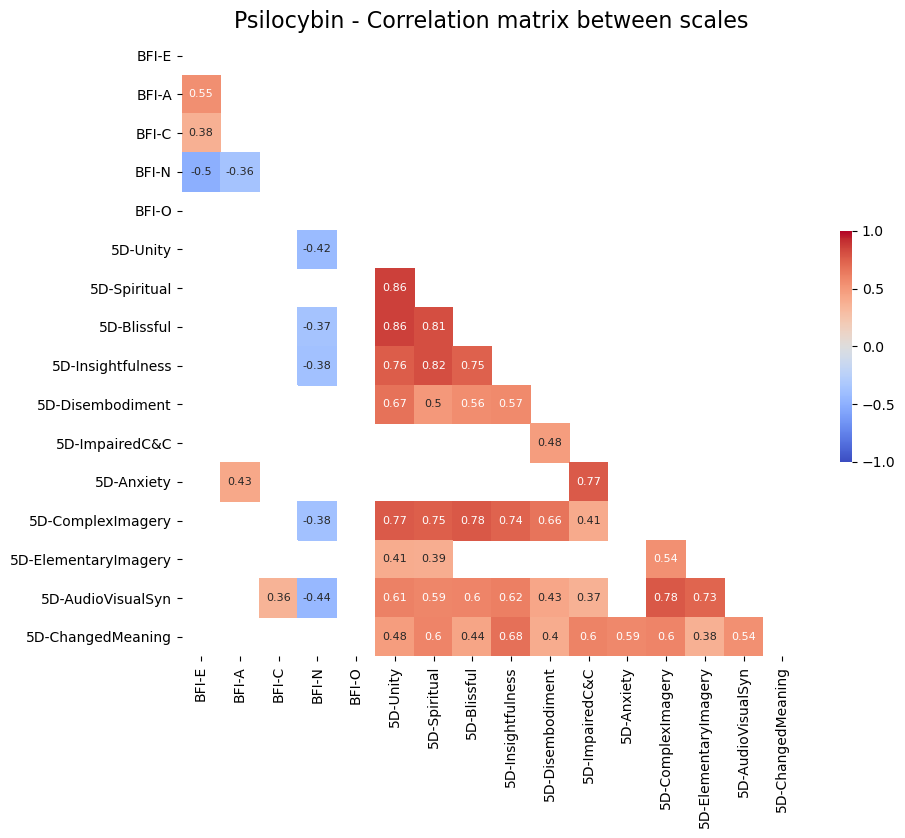

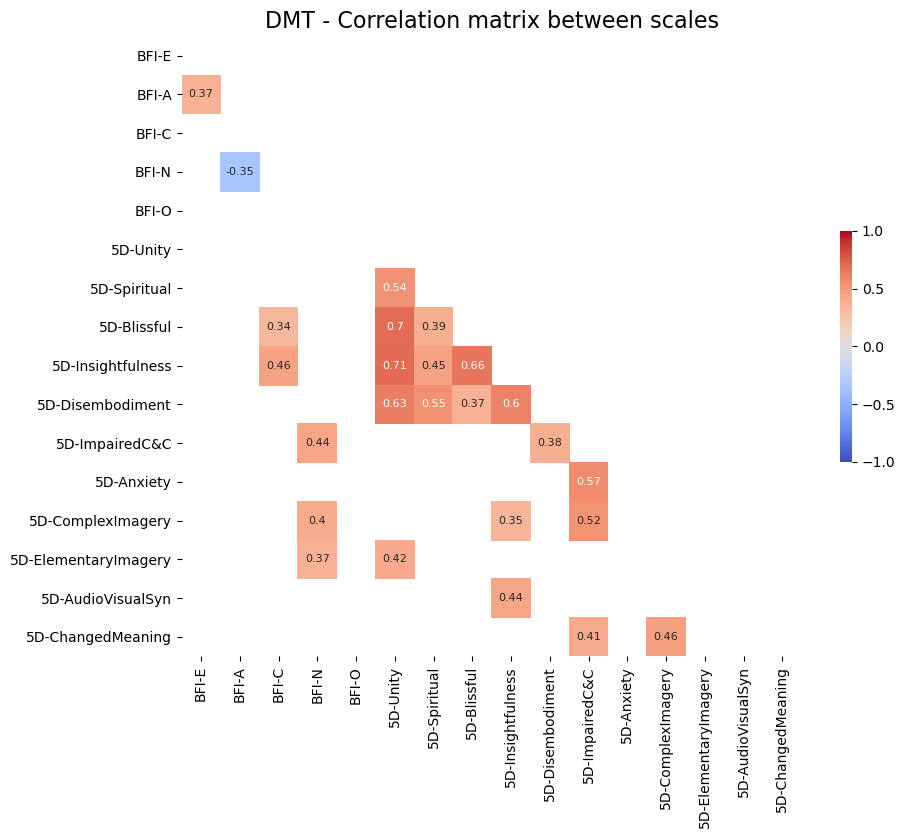

In [28]:
column_list = [col for col in psilo_df if (col.endswith('_reranged'))]

cols_labels = [col.replace('_reranged', '') for col in column_list]
rows_labels = [col.replace('_reranged', '') for col in column_list]

method = 'pearson' #spearman                   

plot_corr_matrix(psilo_df[column_list], "Psilocybin - Correlation matrix between scales", cols_labels, rows_labels, 
                 p_value=0.05, r_threshold=0.3, mult_comparison=False, method=method, sq_size=10)

plot_corr_matrix(dmt_df[column_list], "DMT - Correlation matrix between scales", cols_labels, rows_labels, 
                 p_value=0.05, r_threshold=0.3, mult_comparison=False, method=method, sq_size=10)